In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, GRU
from sklearn import metrics
import pickle

In [2]:
# set random seed

tf.random.set_seed(1234)

In [3]:
df = pd.read_excel("static/xlsx/kollam2011-21.xlsx", parse_dates = ['date'], index_col=0)
df = df.interpolate(method="linear", limit_direction="both")

In [4]:
df

,price
date,
2011-01-01,3900.0
2011-01-02,3900.0
2011-01-03,3900.0
2011-01-04,2900.0
2011-01-05,3900.0
...,...
2021-08-27,3000.0
2021-08-28,3000.0
2021-08-29,3000.0


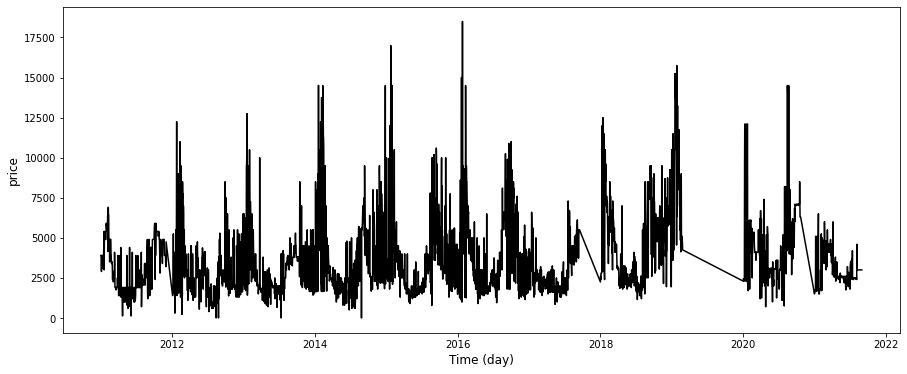

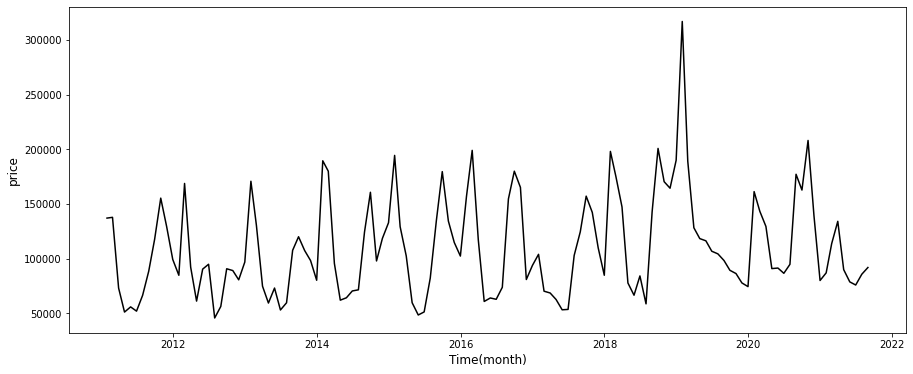

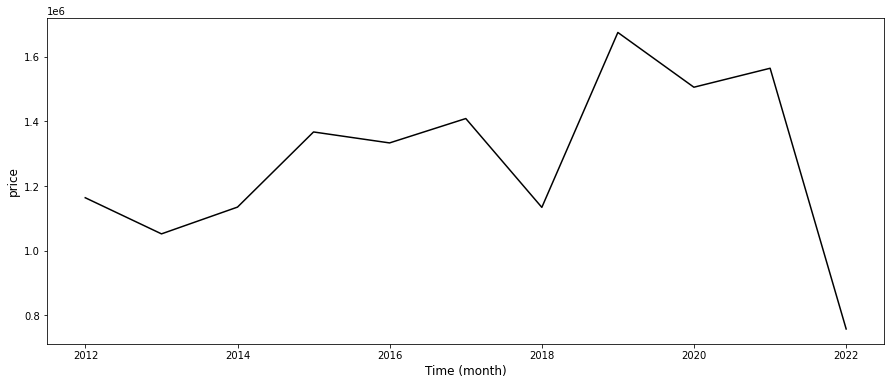

In [5]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (15, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('price', {'fontsize': 12})
dataset = df.copy()
timeseries(df.index, dataset["price"], 'Time (day)')
dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month["price"], 
           'Time(month)')
dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year["price"], 
           'Time (month)')

In [6]:
# Split train data and test data
train_size = int(len(df)*0.8)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]


In [7]:
train_data.shape

(3116, 1)

In [8]:
data = df.iloc[:]

In [9]:
data.shape

(3896, 1)

In [10]:
# min max scaler

scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)
data_scaled = scaler.transform(data)

In [11]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)

# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)
print('data.shape: ', data.shape)

X_train.shape:  (3086, 30, 1)
y_train.shape:  (3086, 1)
X_test.shape:  (750, 30, 1)
y_test.shape:  (750, 1)
data.shape:  (3896, 1)


In [12]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [13]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 40,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)


Epoch 1/40
155/155 [==============================] - 9s 38ms/step - loss: 0.0110 - val_loss: 0.0069
Epoch 2/40
155/155 [==============================] - 5s 31ms/step - loss: 0.0093 - val_loss: 0.0068
Epoch 3/40
155/155 [==============================] - 5s 31ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 4/40
155/155 [==============================] - 5s 32ms/step - loss: 0.0089 - val_loss: 0.0068
Epoch 5/40
155/155 [==============================] - 5s 31ms/step - loss: 0.0086 - val_loss: 0.0070
Epoch 6/40
155/155 [==============================] - 5s 31ms/step - loss: 0.0087 - val_loss: 0.0068
Epoch 7/40
155/155 [==============================] - 5s 31ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 8/40
155/155 [==============================] - 5s 32ms/step - loss: 0.0086 - val_loss: 0.0070
Epoch 9/40
155/155 [==============================] - 5s 31ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 10/40
155/155 [==============================] - 5s 31ms/step - loss: 0.0084 - val_lo

In [14]:
# inverse transform

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)
data_transform = scaler.inverse_transform(data_scaled)

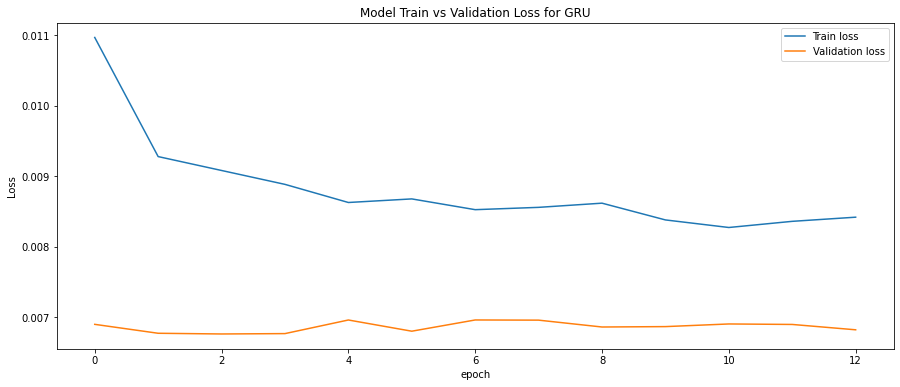

In [15]:
# evaluate model's performance

def plot_loss (history, model_name):
    plt.figure(figsize = (15, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')



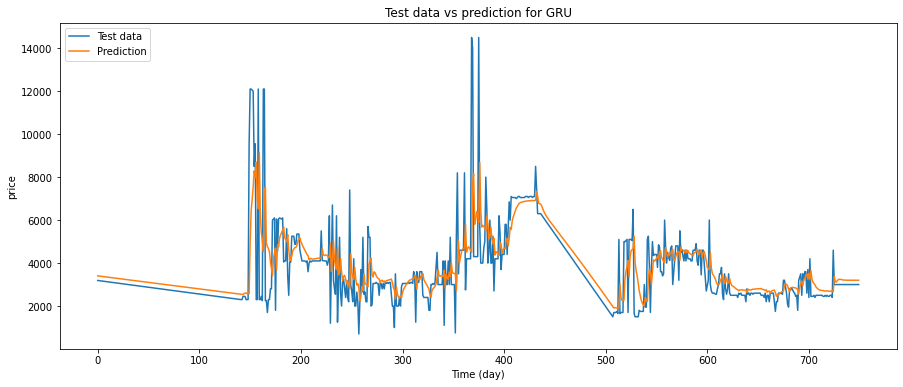

In [16]:
# compare prediction vs test data

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(15, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('price')
 
plot_future(prediction_gru, 'GRU', y_test)


In [17]:
# calculate RMSE and MAE

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')


GRU:
Mean Absolute Error: 705.6337
Root Mean Square Error: 1288.8031



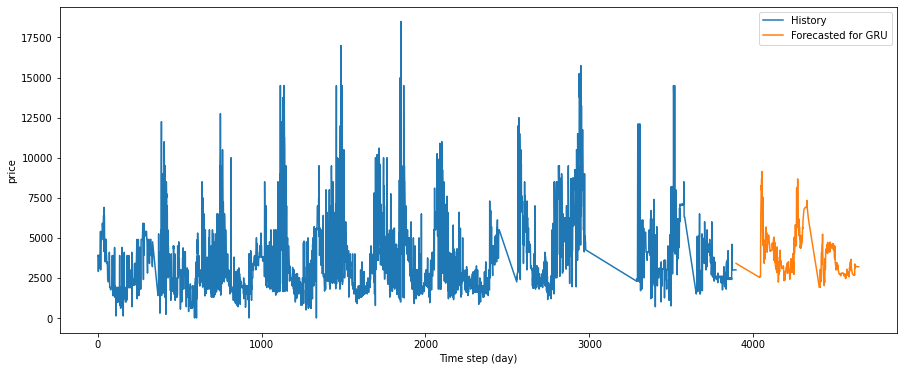

In [18]:
# multi step forecasting

# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_test[-365:])
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru1 = prediction(model_gru)

# Plot history and future
def plot_multi_step(history, prediction1):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history +
                        len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), 
             label='History')
    plt.plot(range_future, np.array(prediction1),
             label='Forecasted for GRU')
      
    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('price')
        
plot_multi_step(df, prediction_gru)


In [19]:
df1=pd.DataFrame()

In [20]:
df1['date'] = pd.date_range("2021-09-01", periods=750, freq="D")

In [21]:
df1['price'] = prediction_gru

In [22]:
df1=df1.set_index('date')

In [23]:
df1.to_pickle('gru_forecast.pkl')

In [24]:
df2 = pd.read_pickle("gru_forecast.pkl")

In [25]:
df2

,price
date,
2021-09-01,3403.800781
2021-09-02,3397.790527
2021-09-03,3391.779297
2021-09-04,3385.767334
2021-09-05,3379.754395
...,...
2023-09-16,3200.421875
2023-09-17,3200.400391
2023-09-18,3200.386475


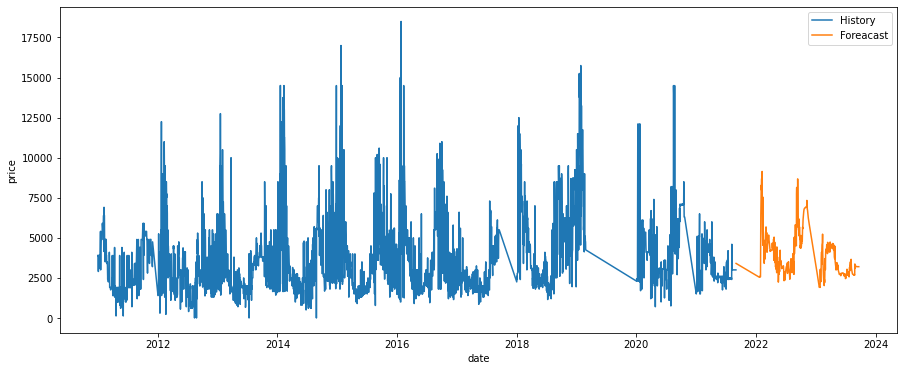

In [26]:
# Plot history and future
def plot_multi_step(history, prediction1):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(df)
    range_future = len(df2)
    plt.plot(df,label='History')
    plt.plot(df2,label='Foreacast')
      
    plt.legend(loc='upper right')
    plt.xlabel('date')
    plt.ylabel('price')
        
plot_multi_step(df, df2)

In [27]:
prediction_gru.tofile('kollam gru predictions.csv', sep=',')

In [28]:
prediction_gru

array([[3403.8008],
       [3397.7905],
       [3391.7793],
       [3385.7673],
       [3379.7544],
       [3373.7397],
       [3367.7253],
       [3361.709 ],
       [3355.6921],
       [3349.6743],
       [3343.6558],
       [3337.6357],
       [3331.615 ],
       [3325.5938],
       [3319.571 ],
       [3313.5476],
       [3307.523 ],
       [3301.4976],
       [3295.4712],
       [3289.4438],
       [3283.4155],
       [3277.3865],
       [3271.3564],
       [3265.3254],
       [3259.2932],
       [3253.2603],
       [3247.2266],
       [3241.1914],
       [3235.156 ],
       [3229.1187],
       [3223.081 ],
       [3217.0425],
       [3211.0027],
       [3204.9622],
       [3198.9207],
       [3192.8784],
       [3186.8345],
       [3180.7905],
       [3174.7454],
       [3168.6987],
       [3162.6516],
       [3156.6035],
       [3150.5544],
       [3144.5046],
       [3138.4536],
       [3132.4016],
       [3126.3484],
       [3120.2952],
       [3114.24  ],
       [3108.1843],
